## Import Libraries

In [91]:
import sys 
sys.path.append('C:/Users/yemre/Masaüstü/Data_Science_Projects/Churn_Prediction/src')

In [92]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import warnings

from data_analysis import DataAnalysis
from data_preprocessor import Preprocessor
from dataloader import DataLoader
from model_trainer import ModelTrainer
from model_evaluator import ModelEvaluator


import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import optuna

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


## Load data and Preprocessing

#

In [93]:
data = DataLoader.get_data('../data/dataset.csv')

Data loaded from file path ../data/dataset.csv


In [94]:
print(f"data shape is {data.shape}")

data shape is (7043, 21)


## Categorize Columns

In [95]:
numeric_cols, categoric_cols, date_cols = DataAnalysis.categorize_columns(data=data)
print(f"numeric cols: \n{numeric_cols}")
print("*"*50)
print(f"categoric cols: \n{categoric_cols}")
print("*"*50)
print(f"date cols: \n{date_cols}")

Starting categorize columns...
numeric cols: 
['SeniorCitizen', 'tenure', 'MonthlyCharges']
**************************************************
categoric cols: 
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']
**************************************************
date cols: 
[]


In [96]:
DataAnalysis.check_dtype_cols(data=data, col_types_list=numeric_cols)

SeniorCitizen type is int64
Check the first 3 rows of the column: 
0    0
1    0
2    0
Name: SeniorCitizen, dtype: int64
tenure type is int64
Check the first 3 rows of the column: 
0     1
1    34
2     2
Name: tenure, dtype: int64
MonthlyCharges type is float64
Check the first 3 rows of the column: 
0    29.85
1    56.95
2    53.85
Name: MonthlyCharges, dtype: float64


In [97]:
DataAnalysis.check_dtype_cols(data=data, col_types_list=categoric_cols)

customerID type is object
Check the first 3 rows of the column: 
0    7590-VHVEG
1    5575-GNVDE
2    3668-QPYBK
Name: customerID, dtype: object
gender type is object
Check the first 3 rows of the column: 
0    Female
1      Male
2      Male
Name: gender, dtype: object
Partner type is object
Check the first 3 rows of the column: 
0    Yes
1     No
2     No
Name: Partner, dtype: object
Dependents type is object
Check the first 3 rows of the column: 
0    No
1    No
2    No
Name: Dependents, dtype: object
PhoneService type is object
Check the first 3 rows of the column: 
0     No
1    Yes
2    Yes
Name: PhoneService, dtype: object
MultipleLines type is object
Check the first 3 rows of the column: 
0    No phone service
1                  No
2                  No
Name: MultipleLines, dtype: object
InternetService type is object
Check the first 3 rows of the column: 
0    DSL
1    DSL
2    DSL
Name: InternetService, dtype: object
OnlineSecurity type is object
Check the first 3 rows of the 

In [98]:
# Total Charges column has a object data type but it is numerical data, so let's change data type for this column.
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Add TotalCharges in numeric list and remove it from categoric list
numeric_cols.append('TotalCharges')
categoric_cols.remove('TotalCharges')

## Descriptive Stats and Distributions for Numeric Features

In [99]:
#Check Descriptive Stats for Numeric Columns
DataAnalysis.descriptive_stats_for_numeric_cols(data=data.loc[:,numeric_cols])

AttributeError: 'DataFrame' object has no attribute 'append'

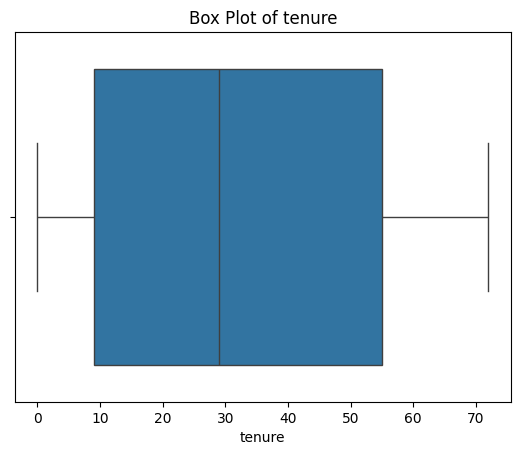

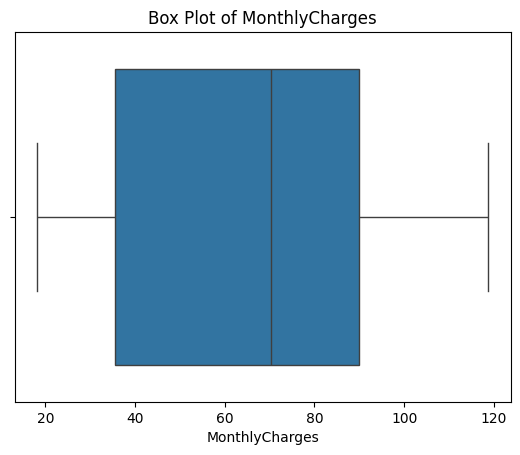

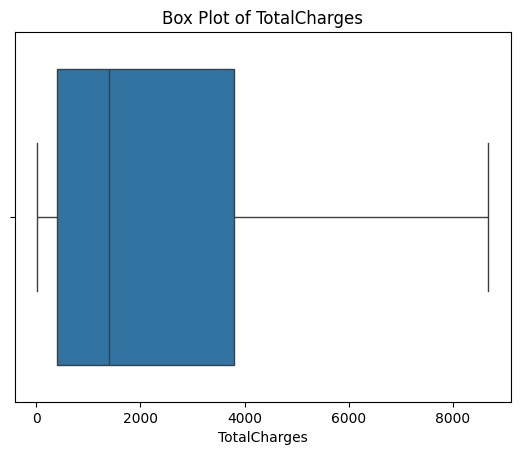

In [ ]:
DataAnalysis.plot_boxplot(data=data, feature_name='tenure')
DataAnalysis.plot_boxplot(data=data, feature_name='MonthlyCharges')
DataAnalysis.plot_boxplot(data=data, feature_name='TotalCharges')

Tenure, MonthlyCharges, and TotalCharges have outliers. Should determine outlier values and fix them, especially for logistic regression.

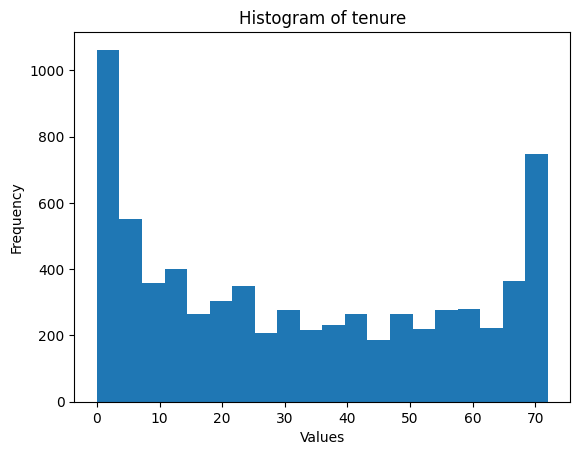

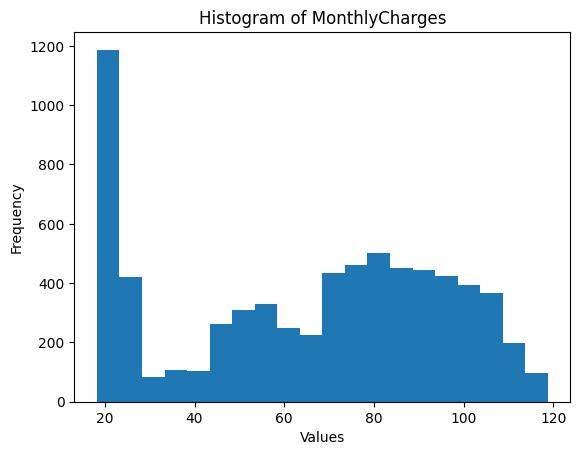

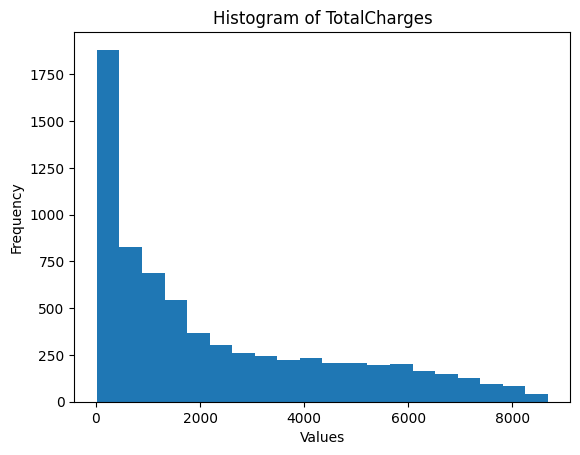

In [ ]:
DataAnalysis.plot_histogram(data=data, feature_name='tenure')
DataAnalysis.plot_histogram(data=data, feature_name='MonthlyCharges')
DataAnalysis.plot_histogram(data=data, feature_name='TotalCharges')

All of the three numeric features have skewness. Especially TotalCharges is very skewed. 

## Analysis for Categoric Features

In [ ]:
DataAnalysis.description_for_categoric_cols(data=data.loc[:,categoric_cols])

AttributeError: 'DataFrame' object has no attribute 'append'

There are no ordinal or hierarchical relations for categorical features. Additionally, the number of unique values is not excessively high. Therefore, applying one-hot encoding would be more reasonable than using label encoding.

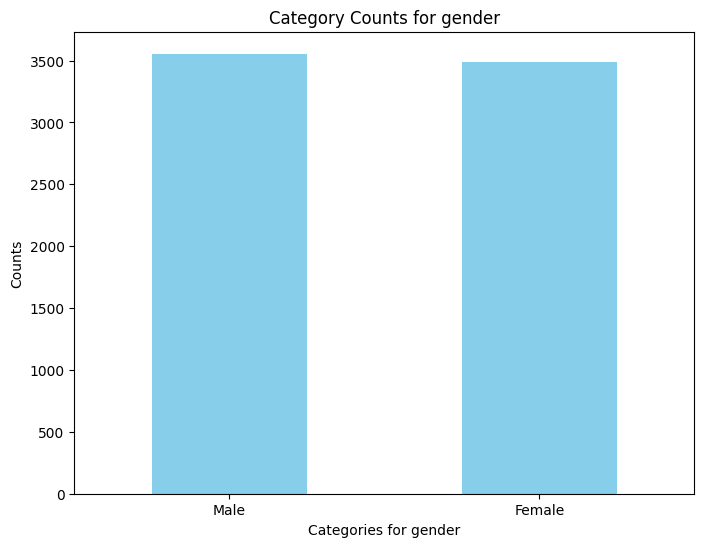

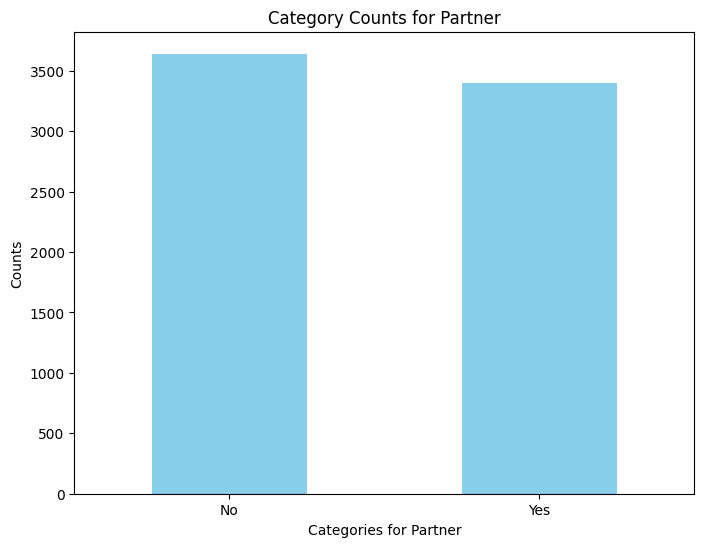

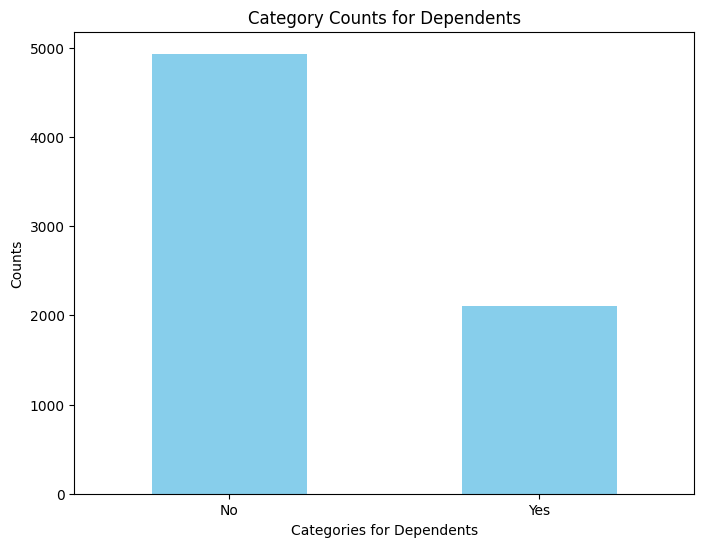

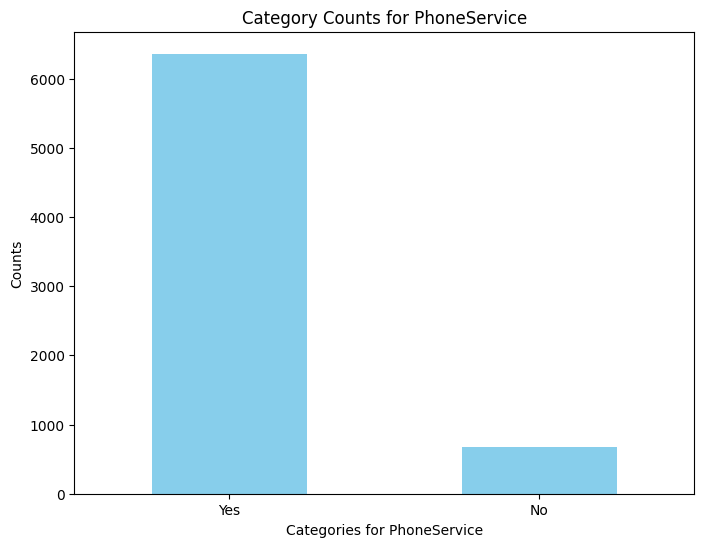

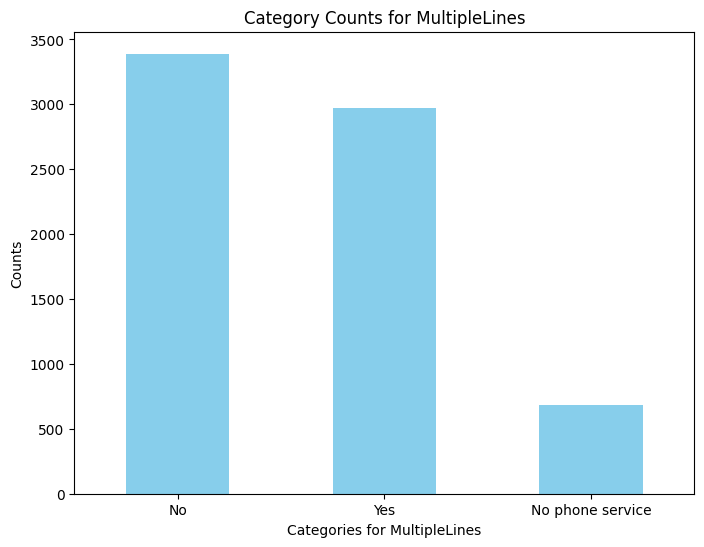

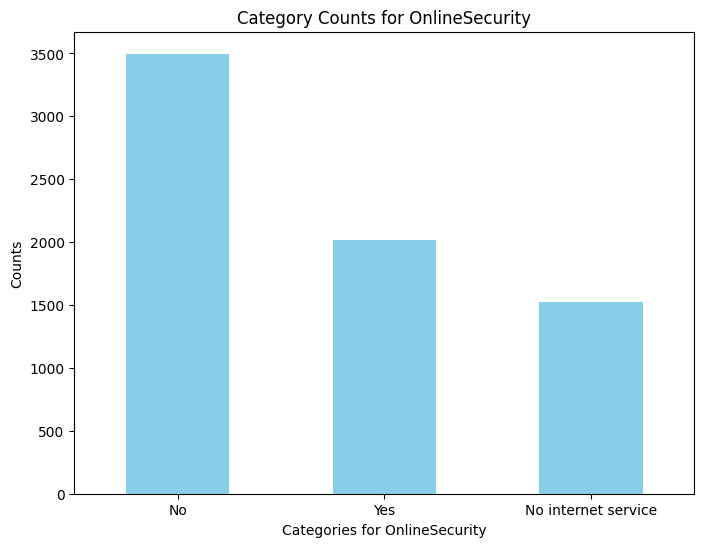

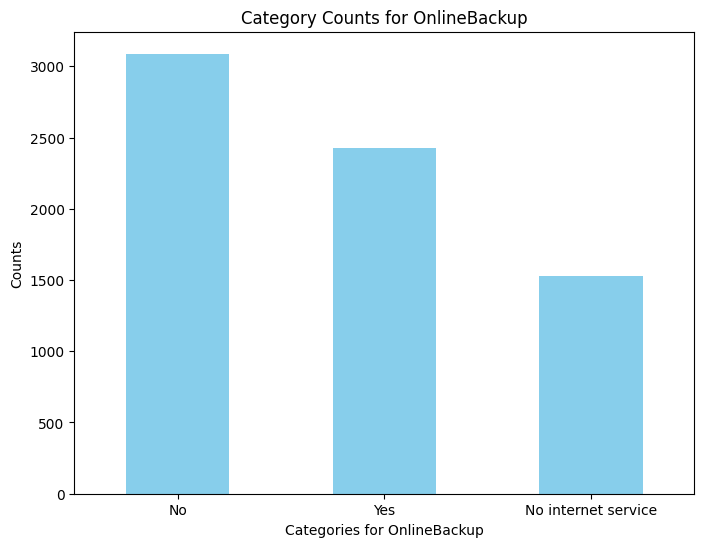

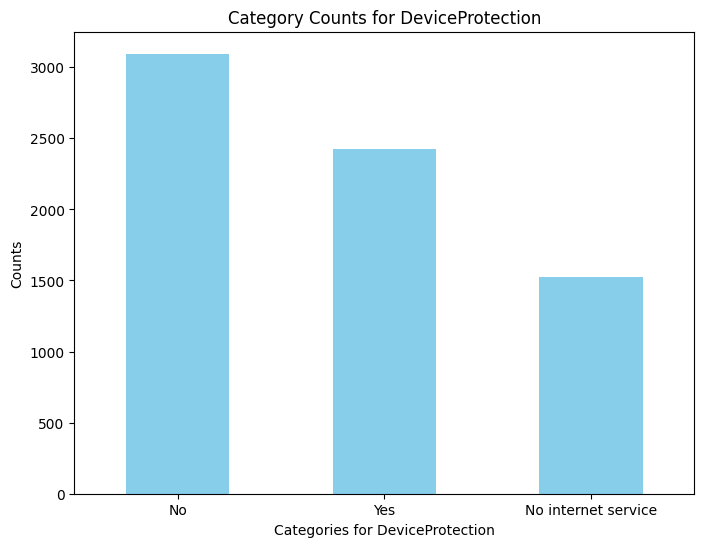

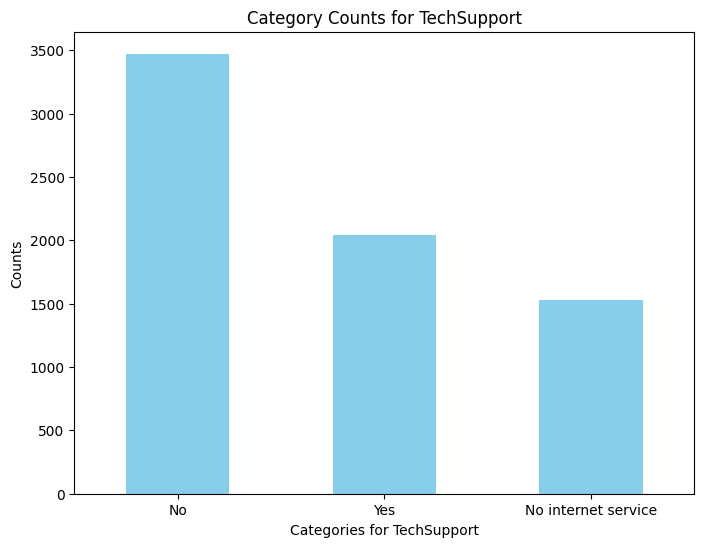

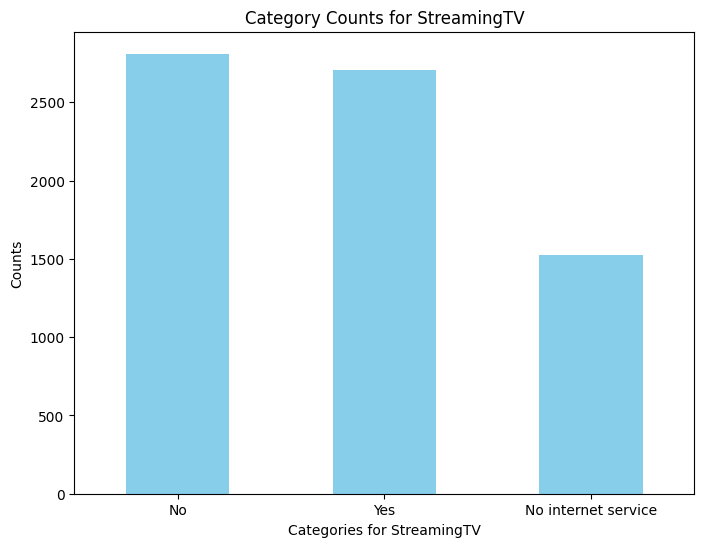

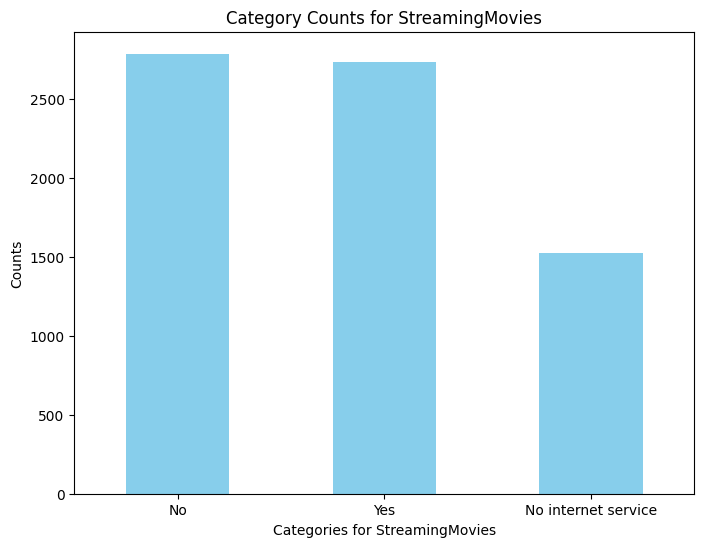

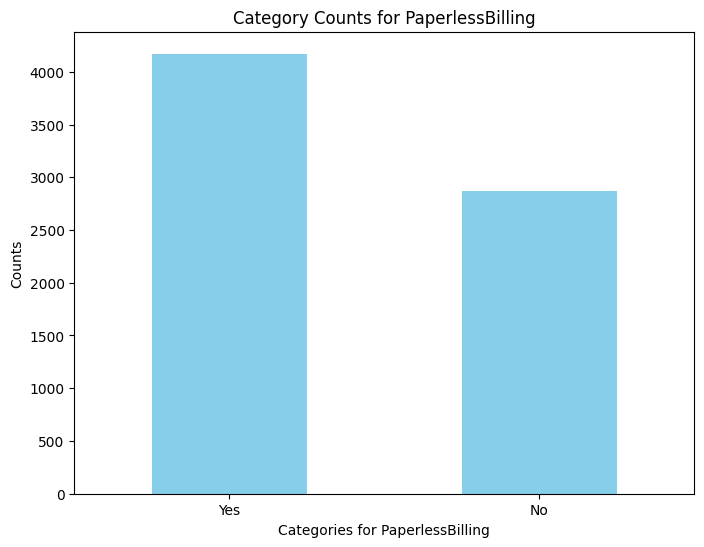

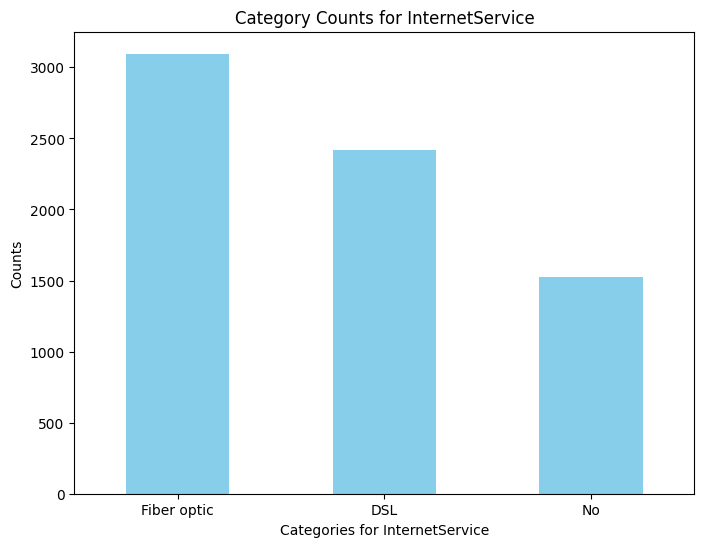

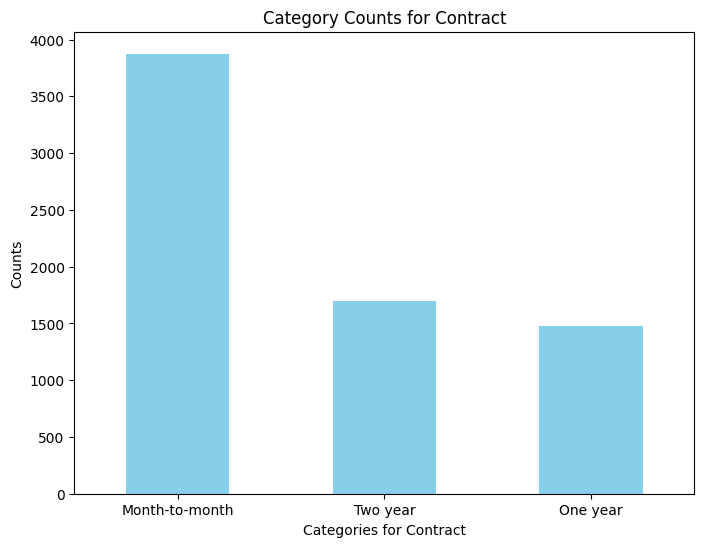

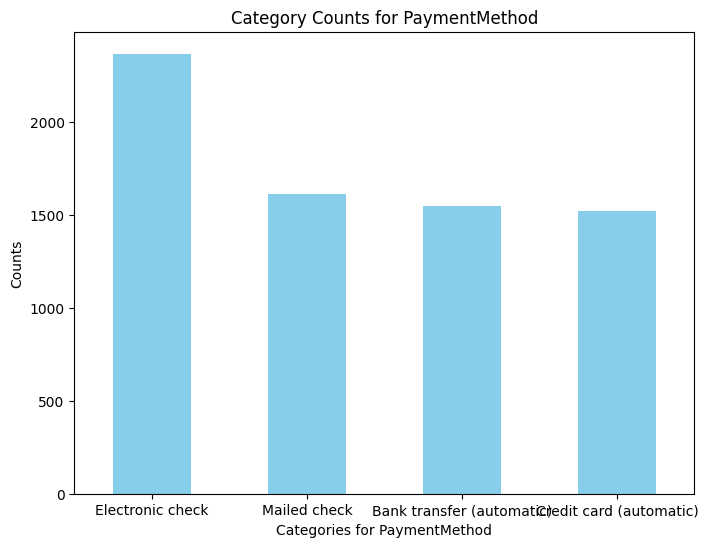

In [ ]:
categoric_column_list = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup", 
                         "DeviceProtection","TechSupport", "StreamingTV", "StreamingMovies","PaperlessBilling","InternetService",  
                         "Contract", "PaymentMethod"]

for column in categoric_column_list:
    DataAnalysis.bar_plot_categoric_feat(data=data, feature_name=column)

## Cardinality Issue for All Features

Low cordinality/Constant Column: 

A column that has the same value for every row in a dataset is often considered uninformative and can be a problem in data analysis or machine learning, as it doesn't provide any information.

High Cardinality: 

When each row in a dataset has a unique value. High cardinality features can present challenges for modeling, as they can lead to a large number of unique categories, which can make the data more difficult to work with.

In [100]:
data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64

The data has many constant features and columns with high cardinality problem.

Low cordinality columns:

Count column
Country column
State column
High cordinality columns:

CustomerID column.
Zip Code column.

## Imputation for Missing Values

In [101]:
#Before imputation, check duplicate columns and rows
print(f"Check duplicate columns: \n{Preprocessor.check_duplicate_cols(data)}")
print('*'*75)
print(f"Check duplicate rows: \n{Preprocessor.check_duplicate_rows(data)}")

Check duplicate columns: 
[]
***************************************************************************
Check duplicate rows: 
Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []


In [102]:
Preprocessor.return_only_missing_counts(data=data)

TotalCharges has 11 missing values.


In [103]:
# we have the number of months that the customer uses the service, Tenure Months, and Monthly Charges. we can replace null values with those calculated by monthly charges * tenure months
data['TotalCharges'].fillna(data['MonthlyCharges'] * data['tenure'], inplace=True)

## Encoding Part

In [104]:
# encode categorical data using one-hot encoding or label encoding
cols_to_use = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
              "TechSupport", "StreamingTV", "StreamingMovies","PaperlessBilling","InternetService",  "Contract", "PaymentMethod"]


for column in cols_to_use:
    data = Preprocessor.one_hot_encoder(data, column)

print(data.columns)

Index(['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'gender_Female', 'gender_Male', 'Partner_No',
       'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 

## Split Data and Model Trials

In [105]:
# delete customerID columns
del data['customerID']
#Convert target feature to binary variable
data['Churn'] = pd.to_numeric(data['Churn'].replace({'No':0, 'Yes':1}))
y = data['Churn']
X = data.drop('Churn', axis=1)

'''
Cross validation

'''
X_train, X_test, y_train, y_test = Preprocessor.split_data(X, y)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 45 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7043 non-null   int64  
 1   tenure                                   7043 non-null   int64  
 2   MonthlyCharges                           7043 non-null   float64
 3   TotalCharges                             7043 non-null   float64
 4   gender_Female                            7043 non-null   bool   
 5   gender_Male                              7043 non-null   bool   
 6   Partner_No                               7043 non-null   bool   
 7   Partner_Yes                              7043 non-null   bool   
 8   Dependents_No                            7043 non-null   bool   
 9   Dependents_Yes                           7043 non-null   bool   
 10  PhoneService_No                          7043 no

In [106]:
#Calculate Univariate Gini for Feature Selection Part 
univariate_gini_scores = Preprocessor.calculate_univariate_gini(data,'Churn', X_test, y_test)
sorted_univariate_gini_scores = univariate_gini_scores.sort_values(by='Gini_Score', ascending=False)
print(sorted_univariate_gini_scores.head(15))

                            Feature_Name  Gini_Score
1                                 tenure    0.524989
38               Contract_Month-to-month    0.455682
2                         MonthlyCharges    0.434672
3                           TotalCharges    0.431132
24                        TechSupport_No    0.387310
15                     OnlineSecurity_No    0.381782
36           InternetService_Fiber optic    0.352394
43        PaymentMethod_Electronic check    0.348464
40                     Contract_Two year    0.303697
18                       OnlineBackup_No    0.289863
21                   DeviceProtection_No    0.285189
22  DeviceProtection_No internet service    0.215640
28       StreamingTV_No internet service    0.215640
25       TechSupport_No internet service    0.215640
19      OnlineBackup_No internet service    0.215640


## We can proceed with the first 15 features during model trials; however, since the total count of features is not high, no feature reduction method will be applied.


## Experiment on Different Models

We have many models to use:
grid search(computational high)/ random search (not good)


data manipulating

1. xgboost # can handle missing values # learn misclassification

use grid search 

optima, huper tuning

website: xgboost

subsample 

2. Random Forest  # learn positive classification

use random/optima methods # comapre the two tuning method


3. Logistic regression # cannot handle missing/outliers/correlations

scaling methods

correlation implementation

category ratio, robust scaling, correlation methods

drop one if corr >50/70, with low gini score



Cross Validation Score :  82.15%
ROC_AUC Score :  69.10%
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409



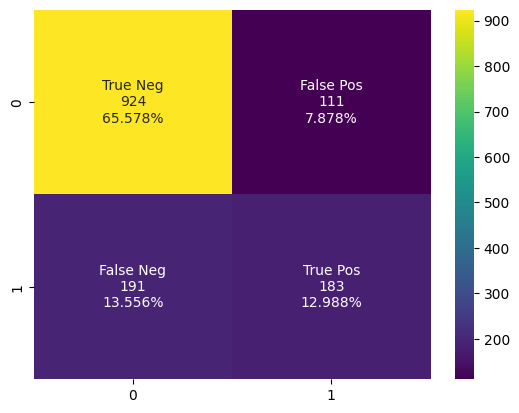

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier()

ModelTrainer(xgb_model, X_train,y_train, X_test,y_test)
ModelEvaluator(xgb_model,X_test,y_test)

[I 2023-11-27 17:27:49,525] A new study created in memory with name: no-name-5e410b64-385a-4552-885f-f1766496fe60
[I 2023-11-27 17:27:49,872] Trial 0 finished with value: 0.7345635202271115 and parameters: {'n_estimators': 101, 'max_depth': 14, 'min_child_weight': 2, 'gamma': 0.0004443203941140586, 'learning_rate': 0.0004386536282919884, 'subsample': 0.7463317666606968, 'colsample_bytree': 0.824648050767119}. Best is trial 0 with value: 0.7345635202271115.
[I 2023-11-27 17:27:51,580] Trial 1 finished with value: 0.7345635202271115 and parameters: {'n_estimators': 337, 'max_depth': 13, 'min_child_weight': 4, 'gamma': 0.004151680611065086, 'learning_rate': 3.804499518819801e-05, 'subsample': 0.8718512570118961, 'colsample_bytree': 0.7405715727203155}. Best is trial 0 with value: 0.7345635202271115.
[I 2023-11-27 17:27:52,168] Trial 2 finished with value: 0.7480482611781405 and parameters: {'n_estimators': 236, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.1186992102328224, 'learning_

Best parameters: {'n_estimators': 277, 'max_depth': 19, 'min_child_weight': 3, 'gamma': 0.020975353135193154, 'learning_rate': 0.0435645149569065, 'subsample': 0.2565998501490619, 'colsample_bytree': 0.5004644567909964}
Cross Validation Score :  83.56%
ROC_AUC Score :  72.21%
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1035
           1       0.69      0.53      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



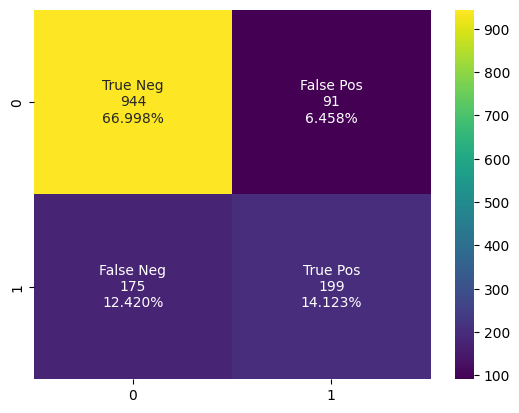

In [ ]:
from sklearn.metrics import accuracy_score


def objective_xgb(trial,X_train, y_train, X_test, y_test):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
    }

    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_xgb(trial, X_train, y_train, X_test, y_test), n_trials=100)

best_params = study.best_trial.params
print("Best parameters:", best_params)


# Train the model with the best parameters
xgb_opt = xgb.XGBClassifier(**best_params)
ModelTrainer(xgb_opt, X_train, y_train, X_test, y_test)
ModelEvaluator(xgb_opt, X_test, y_test)


In [ ]:
LR = LogisticRegression()

ModelTrainer(LR, X_train,y_train, X_test,y_test)
ModelEvaluator(LR,X_test,y_test)



KeyError: "['DeviceProtection_No internet service'] not found in axis"

In [ ]:
For logistics regression: 
- Implement correlation elimination for multicollinerity problem 
- implement scaling methods such as robust scaling (robust can handle outliers) 
- if we use other scaling methods such as standardscaler, drop or cap outliers 

In [ ]:

RanForCla = RandomForestClassifier()

ModelTrainer(RanForCla,X_train,y_train,X_test,y_test)
ModelEvaluator(RanForCla, X_test,y_test)

Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}
Cross Validation Score :  84.56%
ROC_AUC Score :  70.43%
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



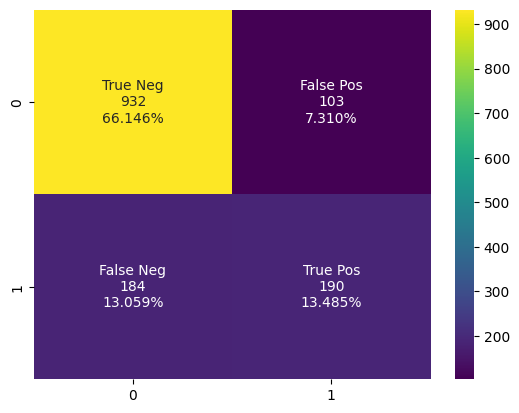

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the model with the best parameters
rf_opt = RandomForestClassifier(**best_params)
ModelTrainer(rf_opt, X_train, y_train, X_test, y_test)
ModelEvaluator(rf_opt, X_test, y_test)


Cross Validation Score :  66.10%
ROC_AUC Score :  50.00%
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



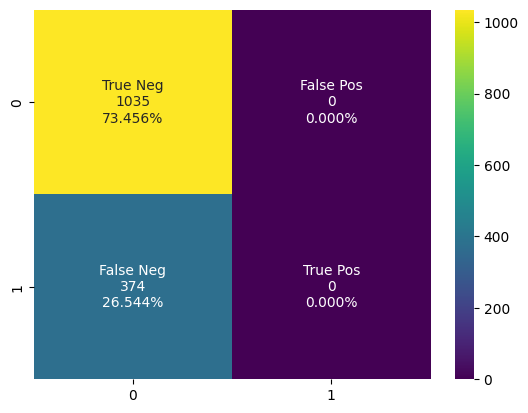

In [113]:
from sklearn.preprocessing import RobustScaler

# 1. Eliminate Multicollinearity
corr_matrix = X.corr().abs()
high_corr_var = np.where(X > 0.8)
high_corr_var = [(X.columns[i], X.columns[j]) for i, j in zip(*high_corr_var) if i != j and i < j]
for var_pair in high_corr_var:
    if var_pair[1] in X.columns:
        X.drop(var_pair[1], axis=1, inplace=True)

# 2. Scaling Data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = Preprocessor.split_data(X_scaled, y)

# Train your model
LR = LogisticRegression()


ModelTrainer(LR, X_train,y_train, X_test,y_test)
ModelEvaluator(LR,X_test,y_test)
